In [2]:
# 1. Instalación de librerías visuales
!pip install -q plotly seaborn matplotlib pandas

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, count, month, year, concat_ws, desc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# --- CONFIGURACIÓN DE CONEXIÓN AL DW ---
DB_HOST = "sql_server"
DB_USER = "sa"
DB_PASS = "PasswordFuerte123!" 
DB_NAME = "DW_AlquilerHabitacion"
DRIVER_PKG = "com.microsoft.sqlserver:mssql-jdbc:11.2.0.jre8"

spark = SparkSession.builder \
    .appName("Analisis-BI-Rental") \
    .master("local[*]") \
    .config("spark.jars.packages", DRIVER_PKG) \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# Función para leer tablas del DW
def leer_tabla(tabla):
    url = f"jdbc:sqlserver://{DB_HOST}:1433;databaseName={DB_NAME};encrypt=true;trustServerCertificate=true;"
    return spark.read.format("jdbc") \
        .option("url", url).option("dbtable", tabla) \
        .option("user", DB_USER).option("password", DB_PASS) \
        .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver").load()

print("--- CARGANDO DATOS DEL DATA WAREHOUSE ---")

# Cargar Hechos y Dimensiones
df_fact = leer_tabla("FACT_PAGO")
df_dim_hab = leer_tabla("DIM_HABITACION")
df_dim_tiempo = leer_tabla("DIM_TIEMPO")
df_dim_cliente = leer_tabla("DIM_CLIENTE")

--- CARGANDO DATOS DEL DATA WAREHOUSE ---


In [8]:
df_analisis = df_fact.alias("f") \
    .join(df_dim_hab.alias("h"), col("f.idHabitacionDW") == col("h.idHabitacionDW")) \
    .join(df_dim_tiempo.alias("t"), col("f.idTiempoDW") == col("t.idTiempoDW")) \
    .join(df_dim_cliente.alias("c"), col("f.idClienteDW") == col("c.idClienteDW")) \
    .select(
        col("t.anio"),
        col("t.mes"),
        col("t.fecha"),
        col("h.tipoHabitacion"),
        col("h.numeroHabitacion"),
        col("h.estado"),
        col("c.nombreCli"),
        col("f.montoPago"),
        col("f.metodoPago")
    )

df_analisis.cache()
print(f"Total de registros analizados: {df_analisis.count()}")
df_analisis.show(5)

Total de registros analizados: 10796
+----+---+----------+--------------+----------------+----------+--------------------+---------+-------------+
|anio|mes|     fecha|tipoHabitacion|numeroHabitacion|    estado|           nombreCli|montoPago|   metodoPago|
+----+---+----------+--------------+----------------+----------+--------------------+---------+-------------+
|2025|  8|2025-08-12|   Matrimonial|             501|Disponible| Lorenzo Calvo Peral|   400.00|         Yape|
|2025|  9|2025-09-11|   Matrimonial|             501|Disponible| Lorenzo Calvo Peral|   400.00|     Efectivo|
|2025| 10|2025-10-11|   Matrimonial|             501|Disponible| Lorenzo Calvo Peral|   400.00|Transferencia|
|2025| 11|2025-11-10|   Matrimonial|             501|Disponible| Lorenzo Calvo Peral|   400.00|Transferencia|
|2024|  1|2024-01-06|   Matrimonial|             501|Disponible|Mariano Marcos Ag...|  1200.00|Transferencia|
+----+---+----------+--------------+----------------+----------+-------------------

In [7]:
# ==========================================
# ANÁLISIS ESTADÍSTICO 
# ==========================================
print("\n--- ESTADÍSTICAS GENERALES DE INGRESOS ---")

# Resumen estadístico del monto de los pagos
df_analisis.select("montoPago").describe().show()

# Resumen avanzado (cuartiles, mediana)
df_analisis.select("montoPago").summary().show()


--- ESTADÍSTICAS GENERALES DE INGRESOS ---
+-------+------------------+
|summary|         montoPago|
+-------+------------------+
|  count|             10796|
|   mean|        696.628381|
| stddev|280.79689964099407|
|    min|            400.00|
|    max|           1200.00|
+-------+------------------+

+-------+------------------+
|summary|         montoPago|
+-------+------------------+
|  count|             10796|
|   mean|        696.628381|
| stddev|280.79689964099407|
|    min|            400.00|
|    25%|             500.0|
|    50%|             600.0|
|    75%|             850.0|
|    max|           1200.00|
+-------+------------------+



In [6]:
print("\n--- KPIs POR TIPO DE HABITACIÓN ---")

# Calculamos Ingreso Total, Promedio por pago y Cantidad de transacciones
df_kpi_habitacion = df_analisis.groupBy("tipoHabitacion").agg(
    sum("montoPago").alias("Ingreso_Total"),
    avg("montoPago").alias("Ticket_Promedio"),
    count("montoPago").alias("Total_Transacciones")
).orderBy(col("Ingreso_Total").desc())

df_kpi_habitacion.show()

# Convertimos a Pandas para graficar
pdf_kpi = df_kpi_habitacion.toPandas()


--- KPIs POR TIPO DE HABITACIÓN ---
+--------------+-------------+---------------+-------------------+
|tipoHabitacion|Ingreso_Total|Ticket_Promedio|Total_Transacciones|
+--------------+-------------+---------------+-------------------+
|         Doble|   1973550.00|     687.887766|               2869|
|   Matrimonial|   1677800.00|     706.739680|               2374|
|        Simple|   1600550.00|     699.541084|               2288|
|         Suite|   1360350.00|     692.290076|               1965|
|     Penthouse|    908550.00|     698.884615|               1300|
+--------------+-------------+---------------+-------------------+




--- GRÁFICOS ESTÁTICOS ---


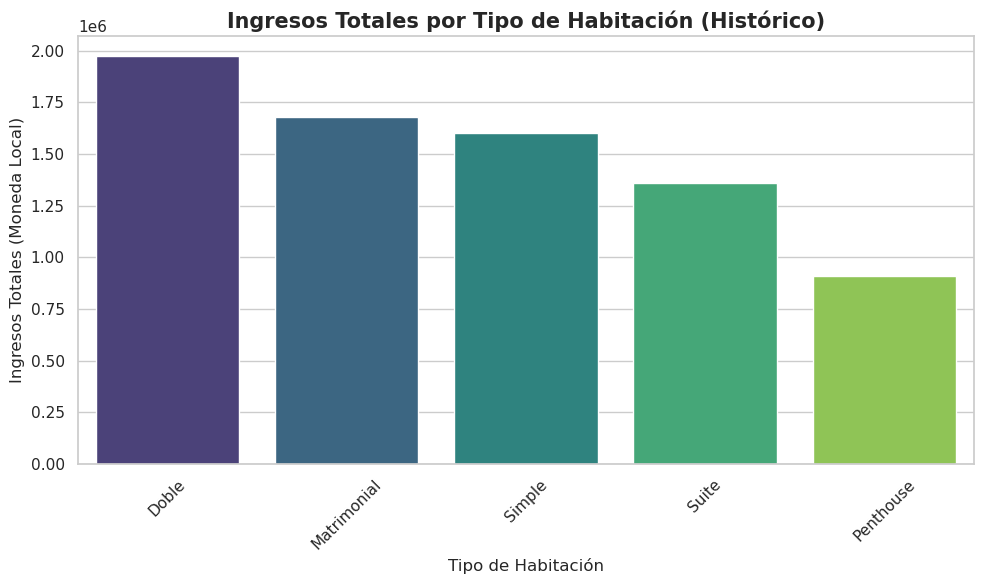

In [9]:
# ==========================================
# VISUALIZACIÓN ESTÁTICA (Matplotlib/Seaborn)
# ==========================================
print("\n--- GRÁFICOS ESTÁTICOS ---")

# Configuración de estilo
sns.set_theme(style="whitegrid")

# Gráfico de Barras: Ingresos Totales por Tipo de Habitación
plt.figure(figsize=(10, 6))

sns.barplot(
    data=pdf_kpi, 
    x="tipoHabitacion", 
    y="Ingreso_Total", 
    hue="tipoHabitacion",  
    palette="viridis",     
    legend=False           
)

plt.title("Ingresos Totales por Tipo de Habitación (Histórico)", fontsize=15, fontweight="bold")
plt.xlabel("Tipo de Habitación", fontsize=12)
plt.ylabel("Ingresos Totales (Moneda Local)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

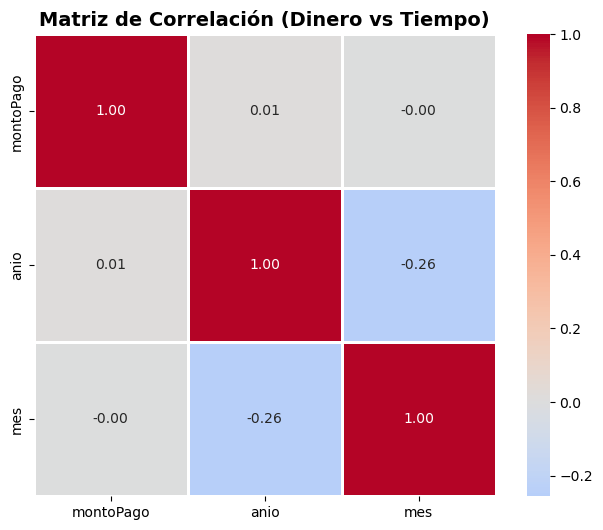

In [4]:
# Matriz de Correlación
# Convertimos todo a pandas para correlación
# Aseguramos que los tipos sean numéricos (float/int) para evitar errores en .corr()
pdf_full = df_analisis.select("montoPago", "anio", "mes").toPandas()
pdf_full["montoPago"] = pd.to_numeric(pdf_full["montoPago"])
pdf_full["anio"] = pd.to_numeric(pdf_full["anio"])
pdf_full["mes"] = pd.to_numeric(pdf_full["mes"])

plt.figure(figsize=(8, 6))
# Calculamos correlación
corr_matrix = pdf_full.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            center=0, square=True, linewidths=1)
plt.title("Matriz de Correlación (Dinero vs Tiempo)", fontsize=14, fontweight="bold")
plt.show()

In [10]:
import plotly.io as pio

pio.renderers.default = "iframe"

# ==========================================
# 4. VISUALIZACIÓN INTERACTIVA (Plotly)
# ==========================================
print("\n--- GRÁFICOS INTERACTIVOS (PLOTLY) ---")

# --- A. EVOLUCIÓN MENSUAL ---
print("   -> Generando gráfico de Evolución (Línea)...")
# Agregamos en Spark
df_evolucion = df_analisis.groupBy("anio", "mes").agg(sum("montoPago").alias("Total_Mes")) \
    .orderBy("anio", "mes")

# Convertimos a Pandas (Aquí Spark trabaja)
pdf_evolucion = df_evolucion.toPandas()

if not pdf_evolucion.empty:
    # Crear columna de fecha para el eje X
    pdf_evolucion['Periodo'] = pdf_evolucion['anio'].astype(str) + '-' + pdf_evolucion['mes'].astype(str).str.zfill(2)

    fig_line = px.line(pdf_evolucion, x='Periodo', y='Total_Mes', 
                  title='Evolución de Ingresos Mensuales',
                  markers=True,
                  labels={'Total_Mes': 'Ingresos ($)', 'Periodo': 'Mes de Facturación'})
    fig_line.update_layout(hovermode="x unified")
    fig_line.show()
else:
    print("       No hay datos para mostrar evolución.")



--- GRÁFICOS INTERACTIVOS (PLOTLY) ---
   -> Generando gráfico de Evolución (Línea)...


In [11]:
# --- B. SUNBURST (Distribución Jerárquica) ---
print("   -> Generando gráfico Sunburst (Distribución)...")
df_jerarquia = df_analisis.groupBy("anio", "tipoHabitacion").agg(sum("montoPago").alias("Total"))
pdf_jerarquia = df_jerarquia.toPandas()

if not pdf_jerarquia.empty:
    fig_sun = px.sunburst(pdf_jerarquia, 
                          path=['anio', 'tipoHabitacion'], 
                          values='Total',
                          title='Distribución de Ingresos por Año y Categoría',
                          color='Total',
                          color_continuous_scale='RdBu')
    fig_sun.show()
else:
    print("      ⚠️ No hay datos para el Sunburst.")

   -> Generando gráfico Sunburst (Distribución)...


In [38]:
# --- C. BOX PLOT (Dispersión) ---
print("   Generando gráfico Box Plot (Outliers)...")
# Tomamos una muestra para no saturar el navegador si hay millones de datos
pdf_box = df_analisis.select("tipoHabitacion", "montoPago").sample(fraction=0.1, seed=42).toPandas()

if not pdf_box.empty:
    fig_box = px.box(pdf_box, x="tipoHabitacion", y="montoPago", 
                     title="Dispersión de Pagos por Tipo de Habitación (Muestra 10%)",
                     color="tipoHabitacion")
    fig_box.show()
else:
    print("      ⚠️ No hay datos para el Box Plot.")


   Generando gráfico Box Plot (Outliers)...


In [13]:
print("\n--- MEJORES CLIENTES ---")

# Agrupar por cliente y sumar lo que han gastado
df_top_clientes = df_analisis.groupBy("nombreCli") \
    .agg(sum("montoPago").alias("Total_Gastado")) \
    .orderBy(col("Total_Gastado").desc()) \
    .limit(10)

pdf_top_cli = df_top_clientes.toPandas()

# Gráfico Horizontal Interactivo
fig_cli = px.bar(pdf_top_cli, x="Total_Gastado", y="nombreCli", orientation='h',
                 title="Mejores 10 Clientes (Mayor Inversión)",
                 color="Total_Gastado",
                 color_continuous_scale="Blugrn")
fig_cli.update_layout(yaxis=dict(autorange="reversed")) # El mejor arriba
fig_cli.show()


--- MEJORES CLIENTES ---


In [47]:
print("\n--- PREFERENCIA DE PAGO ---")

df_pagos = df_analisis.groupBy("metodoPago").count().orderBy(desc("count"))
pdf_pagos = df_pagos.toPandas()

# Gráfico de Dona
fig_pie = px.pie(pdf_pagos, values='count', names='metodoPago', 
                 title='Distribución de Métodos de Pago',
                 hole=0.4, # Hace que sea una dona
                 color_discrete_sequence=px.colors.qualitative.Pastel)
fig_pie.update_traces(textposition='inside', textinfo='percent+label')
fig_pie.show()


--- PREFERENCIA DE PAGO ---
